In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
import csv
import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import community
from collections import OrderedDict
import time
import requests
import seaborn as sns
import math
import numpy as np
import os
from pyvis import network as net
import random
import unidecode
import json

In [3]:
%%appyter code_exec

{% do SectionField(
    name="GENES",
    title="Submit a gene list",
) %}


'''
gene_list = {{ TextField(
    name="gene_list",
    label="Gene list",
    description="Paste with a single gene on each line.",
    section="GENES",
    default="",
)}}
'''

n_genes = {{ IntField(
    name="n_genes",
    label="Minimum number of genes per cluster",
    section="GENES",
    default=20,
    minimum=2,
    maximum=1000000
)}}

gene_list_selection = '''{{ ChoiceField(
    name = "gene_list_selection",
    label="Sample gene list to load",
    section="GENES",
    default="SARS-CoV-2_down",
    choices=["SARS-CoV-2_down","ULK4_293_coIP_hits"]
)}}'''

edge_types = {{ MultiCheckboxField(
    name = "edge_types",
    label="Types of edges to use to construct the network",
    section="GENES",
    default=["Gene-gene co-expression","Protein-protein interactions"],
    choices={"Gene-gene co-expression": "Coexpression","Protein-protein interactions": "PPI"}
)}}

sars_list = 5

```python
'''
gene_list = ''''''
'''
n_genes = 20
gene_list_selection = '''SARS-CoV-2_down'''
edge_types = ['Gene-gene co-expression', 'Protein-protein interactions']
sars_list = 5
```

In [4]:
# Load data
cloud_url = 'https://appyters.maayanlab.cloud/storage/Gene_Network_Analysis/'

In [5]:
print(edge_types)

['Gene-gene co-expression', 'Protein-protein interactions']


In [6]:
# Load sample gene lists

if gene_list_selection == "ULK4_293_coIP_hits":
    with open("ULK4_293_coIP_hits.txt","r") as f_in:
        writer = csv.reader(f_in, lineterminator='\n')
        sample_genes = [item for sublist in writer for item in sublist if len(sublist) > 0]
        gene_lists = [[ x.upper() for x in sample_genes ]]
elif gene_list_selection == "SARS-CoV-2_down":
    df_genes = pd.read_csv(cloud_url + "gene_lists/SARS-CoV-2_down.csv",header=None).drop(columns=[0,1])
    df_genes = df_genes.transpose()
    gene_lists = df_genes.to_dict("list")
    for k,v in gene_lists.items():
        gene_lists[k] = [unidecode.unidecode(x) for x in v if isinstance(x, str)] # filter out NaNs     

In [7]:
print(len(gene_lists))

17


In [8]:
df_ppi_edges = pd.read_csv(cloud_url + 'ppi_edges_list.csv',header=None)
#df_gene_edges = pd.read_csv(cloud_url + 'gene_edges_list.csv')
df_gene_edges = pd.read_csv(cloud_url + 'top_500_correlation.csv')

display(df_ppi_edges.head())
print(df_ppi_edges.shape)
display(df_gene_edges.head())
print(df_gene_edges.shape)

,0,1
0,S100A8,LGALS7B
1,S100A8,IGSF21
2,S100A8,IVL
3,S100A8,SERPINB3
4,S100A8,NCF2


(282532, 2)


,A1BG,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,ITIH1,PAH,ITIH2,PPL,ARRDC5,ALPPL2,METTL7B,SNRPA,SLC35E3,TP53I13,...,CSE1L,MCM6,YBX1P4,CPS1,NSA2,CA5A,PPP1R3A,GNAI2,GAREM1,MAP2K6
1,AGXT,SLC2A2,AHSG,TGM1,RP11.927P21.9,KLRG2,SSTR5,RUVBL2,PEX26,RENBP,...,NPM1,TIMELESS,RP11.475I24.1,CKAP2P1,CICP27,FAM98C,TXLNB,TGFB1,DHRS12,HSBP1
2,CYP4A11,CPB2,IGFBP1,KLK13,CSPG4P11,FGF4,C2ORF82,PLK1,ZNF793,PRRT4,...,RAN,SAA3P,REM2,GLP2R,RPL10AP5,PCDHB1,TRDN,PXN,ATP5LP3,POT1
3,C8B,APOH,ITIH3,SCEL,SMIM2,NLRP7,KLHL4,CDC20,RPS6KA5,PPOX,...,LDHB,PSMC5,RP5.1147A1.1,RP11.91J3.1,RPL21P3,USHBP1,XIRP2,VASP,GPR162,SNRPGP14
4,SLC25A47,ALB,AGT,KRT78,RP11.123K3.4,DNMT3L,SPIC,KIF22,ZNF556,AQP7P1,...,PAICS,RFC3,SMCR8,MTNR1A,RPL37P1,ZBTB8B,PYGM,SPI1,RPL27A,GOLGA2P2Y


(500, 26415)


In [9]:
ppi_edges_dict = {}

for index, row in df_ppi_edges.iterrows():
    if row[0] in ppi_edges_dict:
        ppi_edges_dict[row[0]].append(row[1])
    else:
        ppi_edges_dict[row[0]] = [row[1]]
        
gene_edges_dict = df_gene_edges.to_dict('list')

In [10]:

'''
def get_relevant_ppi_edges(gene_list):
    edges = []
    for gene in gene_list:
        if gene in ppi_edges_dict:  
            edges = [*edges,  *[(gene, x) for x in ppi_edges_dict[gene]]]
    return edges

def get_relevant_gene_edges(gene_list):
    edges = []
    for gene in gene_list:
        if gene in gene_edges_dict:  
            edges = [*edges,  *[(gene, x) for x in gene_edges_dict[gene]]]
    return edges
'''

def get_relevant_ppi_edges(gene_list):
    edges = []
    missing = []
    for gene_a in gene_list:
        if gene_a in ppi_edges_dict:
            for gene_b in ppi_edges_dict[gene_a]:
                if gene_b == gene_a: continue
                if gene_b in gene_list: edges.append((gene_a, gene_b))      
        else: missing.append(gene_a)
    return edges,missing

def get_relevant_gene_edges(gene_list):
    # use at most the top 3 edges for each gene.
    edges = []
    missing = []
    for gene_a in gene_list:
        gene_count = 0
        if gene_a in gene_edges_dict:
            for gene_b in gene_edges_dict[gene_a]:
                if gene_count >= 3: break 
                if gene_b == gene_a: continue
                if gene_b in gene_list: 
                    gene_count += 1
                    edges.append((gene_a, gene_b))
        else: missing.append(gene_a)
    return edges,missing

def pretty_heading(content):
    num_dashes = len(content) + 2
    num_dashes = max(30,num_dashes)
    print("-"*num_dashes)
    print(content)
    print("-"*num_dashes)    

In [12]:
networks = {}

nums_missing_nodes = []

for list_num, gene_list in gene_lists.items():

    # create the Network object
    pretty_heading(f"Constructing network for gene list {list_num}")
 
    ppi_edges,ppi_missing = get_relevant_ppi_edges(gene_list)
    gene_edges,gene_missing = get_relevant_gene_edges(gene_list)
    
    print("Missing PPI nodes:\n\n", ppi_missing, "\n")
    print("Missing gene-gene co-expression nodes:\n\n", gene_missing, "\n")
    
    both_missing = set(ppi_missing).intersection(set(gene_missing))
    print("Missing nodes for both types of edges:\n\n", both_missing, "\n")
        
    G = nx.Graph(name=list_num)
    G.add_nodes_from(gene_list)
    
    if "Protein-protein interactions" in edge_types:
        G.add_edges_from(ppi_edges,edge_type="PPI")

    if "Gene-gene co-expression" in edge_types:
        G.add_edges_from(gene_edges,edge_type="Coexpression")
        
    hits = []
    
    for edge in G.edges:
        hits.append(edge[0])
        hits.append(edge[1])
        
    num_missing = len(gene_list) - len(list(set(hits)))
    print(num_missing, " disconnected or missing nodes\n")
    nums_missing_nodes.append(num_missing)
  
    print(nx.info(G), "\n")
    
    networks[list_num] = G
    
    

    


--------------------------------------
Constructing network for gene list 0
--------------------------------------
Missing PPI nodes:

 ['RNU5B-1', 'SMIM30', 'OTUD6B-AS1', 'MNS1', 'UQCRHL', 'MT1E', 'TMEM60', 'AC078927.1', 'AL138752.2', 'LOC107984142', 'NDUFC1', 'COX16', 'AC005083.1', 'NEIL3', 'CLTRN', 'RPL36A-HNRNPH2', 'YBX1P10', 'RN7SL832P', 'CHCHD2P2', 'ARL 14.00', 'AL445685.3', 'SYNJ2BP-COX16', 'GATA6-AS1', 'PSMC1P1', 'AC134682.1', 'TMEM229B', 'AC124045.1', 'AC073548.1', 'TCN1', 'TMEM156', 'CYSTM1', 'FDCSP', 'H1-5', 'PPM1N', 'SNHG6', 'H2AC11', 'C11orf58', 'IQCK', 'SMIM20', 'SLCO1B3', 'PET100', 'RETREG1', 'H3P6', 'PYURF', 'NEDD8-MDP1', 'AC116533.1', 'EIF2S2P4', 'OCIAD2', 'TSPAN13', 'PLAAT4', 'BRD7P2', 'IFI27L2', 'RPS28P7', 'CFAP298-TCP10L', 'ATP5F1E', 'AL021546.1', 'H3C12', 'ATP5MC3', 'SELENOT', 'AL645922.1', 'ELL2P1', 'ANXA2P2', 'AC097625.2', 'CCDC152', 'MIR1244-1', 'FAIM', 'CT83', 'AC099661.1', 'RPL24P4', 'GLYATL2', 'ABRACL', 'COX6A1', 'NDUFC2', 'COX7B', 'TSTD1', 'ANKRD22', 'LIPA',

Missing PPI nodes:

 ['MYOM3', 'ABHD2', 'THAP5', 'SLC35B2', 'ANKRD50', 'MARS2', 'FAXDC2', 'CEACAM7', 'HCG8', 'CLMN', 'CEMIP', 'SNHG8', 'MT-ATP6', 'SMIM13', 'COL27A1', 'UCA1', 'LOC101929128', 'FAM114A1', 'TMEM170A', 'C12ORF75', 'SERINC5', 'NDNF', 'SOS 1', 'KRT42P', 'LOC101927391', 'C4ORF3', 'NPTN', 'PNCK', 'HPDL', 'LOC105377924', 'SLC5A3', 'SNHG1', 'MUC17', 'NYNRIN', 'OLMALINC', '6-Sep', 'ADPRHL1', 'RETNLB', 'XXYLT1', 'TMEM69', 'LINC01559', 'C1ORF43', 'TOP 1.00', 'RASAL1', 'ADGRF1', 'CNNM1', 'ARL 14.00', 'SLC44A4', 'ACAP2', 'CROCCP2', 'ACER2', 'PIGZ', 'C2ORF42', 'LHFPL2', 'ASAH2B', 'OXR1', 'SETD9', 'KIAA0101', 'EPB41L4A-AS1', 'OR2A4', 'C3ORF62', 'JMJD8', 'ZNF717', '3-Mar', 'B3GALNT2', 'BRWD3', 'ZNF337-AS1', 'USP34', 'FER1L4', 'TMCC1', 'FA2H', 'TCN1', 'NCBP2-AS2', 'HPF1', 'LINC01057', 'FABP6', 'C17ORF100', 'ZNF641', 'LOC644794', 'SSUH2', 'FEM1C', 'CLCA4', 'C6ORF223'] 

Missing gene-gene co-expression nodes:

 ['MT-CYB', 'MT-ND4', 'HCG8', 'SNHG8', 'MT-ATP6', 'UCA1', 'LOC101929128', 'MT-ND

Missing PPI nodes:

 ['WDR81', 'C19ORF47', 'IER5L', 'SAPCD2', 'PRR15', 'DDX12P', 'PIF1', 'TMEM160', 'LRRC14', 'NSDHL', 'PCDH9', 'DISP2', 'SLC25A39', 'C1ORF116', 'ZNF672', 'MPV17L2', 'SLC39A3', 'ZNF787', 'C21ORF58', 'METRN', 'HNF1A-AS1', 'TMPO-AS1', 'MPC2', 'C1QTNF6', 'CYB5B', 'HMGCS1', 'SP9', 'KCNK5', 'C1ORF159', 'MROH6', 'DGCR6', 'MMAB', 'KIAA0895L', 'ZBTB45', 'PRADC1', 'INSL4', 'CD320', 'BRI3BP', 'SLC35A4', 'KRT4', 'JMJD8', 'SLC23A1', 'HS6ST1', 'PAQR4', 'SNHG10', 'KLHDC7A', 'CCDC96', 'MLF 2.00', 'TPPP3', 'RPUSD1', 'ZDHHC12', 'NUBP2', 'ARHGEF39', 'BOP 1.00', 'PRR15L', 'TMEM104', 'MUC13', 'TICRR', 'HPDL', 'TMEM201', 'MFSD3', 'SLC22A18AS', 'IGFBPL1'] 

Missing gene-gene co-expression nodes:

 ['HLA-DMB', 'HNF1A-AS1', 'TMPO-AS1', 'SNHG10', 'MLF 2.00', 'BOP 1.00'] 

Missing nodes for both types of edges:

 {'HNF1A-AS1', 'BOP 1.00', 'MLF 2.00', 'TMPO-AS1', 'SNHG10'} 

6  disconnected or missing nodes

Name: 9
Type: Graph
Number of nodes: 500
Number of edges: 1777
Average degree:   7.1080 


In [13]:
# Clustering
all_clusters = {}

In [14]:
# k_clique_communities

all_clusters["k_clique_communities"] = {}

for num, G in networks.items():

    pretty_heading(f"Computing k_clique_communities for gene list {num}")
    
    c = list(community.k_clique_communities(G, 3)) 
    clusters = [ list(x) for x in c if len(x) > n_genes]
    print(f"Computed {len(clusters)} cluster(s)\n")
    
    print("Cluster sizes:", [len(x) for x in clusters],"\n")

    all_clusters["k_clique_communities"][num] = clusters

------------------------------------------------
Computing k_clique_communities for gene list 0
------------------------------------------------
Computed 1 cluster(s)

Cluster sizes: [254] 

------------------------------------------------
Computing k_clique_communities for gene list 1
------------------------------------------------
Computed 4 cluster(s)

Cluster sizes: [102, 32, 74, 27] 

------------------------------------------------
Computing k_clique_communities for gene list 2
------------------------------------------------
Computed 4 cluster(s)

Cluster sizes: [119, 22, 25, 27] 

------------------------------------------------
Computing k_clique_communities for gene list 3
------------------------------------------------
Computed 3 cluster(s)

Cluster sizes: [32, 159, 37] 

------------------------------------------------
Computing k_clique_communities for gene list 4
------------------------------------------------
Computed 3 cluster(s)

Cluster sizes: [26, 21, 141] 

-----

In [15]:
# Girvan newman communities

all_clusters["girvan_newman"] = {}

for num, G in networks.items():
    pretty_heading(f"Computing girvan_newman communities for gene list {num}")

    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    clusters = [ list(x) for x in next_level_communities if len(x) > n_genes ]
    clusters = [ list(x) for x in clusters if len(x) > n_genes]
    print(f"Computed {len(clusters)} cluster(s)\n") 
    print("Cluster sizes:", [len(x) for x in clusters],"\n")
    print(clusters)
    
    all_clusters["girvan_newman"][num] = clusters

-----------------------------------------------------
Computing girvan_newman communities for gene list 0
-----------------------------------------------------
Computed 2 cluster(s)

Cluster sizes: [385, 29] 

[['YPEL5', 'RPL24P4', 'RPS23', 'MYL12A', 'MRPS21', 'CBX3', 'PCNA', 'SF3B5', 'WDR54', 'RPS25', 'ANXA3', 'MMADHC', 'FANCL', 'SEC61G', 'DYNLL1', 'HLA-DQB1', 'SPAG16', 'SERP1', 'PSMA5', 'SARNP', 'VTCN1', 'YBX1', 'CLU', 'PLEKHB1', 'ARPC5', 'BCAS2', 'EXOSC9', 'SYTL3', 'COMMD6', 'HIGD2A', 'ZMPSTE24', 'ROMO1', 'PPA1', 'COX6A1P2', 'SLIRP', 'RPL30', 'SPP1', 'TMEM11', 'DNAH14', 'MAGT1', 'TXN', 'IDI1', 'MSMO1', 'EIF3E', 'ARL6IP5', 'FEZ1', 'NDUFS2', 'VPS28', 'CDK2AP1', 'COX7CP1', 'IFT43', 'C1GALT1C1', 'RPL10AP6', 'UQCRH', 'SEC62', 'STEAP1', 'CRYZ', 'TIPRL', 'LANCL1', 'HMGB2', 'GPBP1', 'ZMAT2', 'ECH1', 'APBB1', 'DERL2', 'SDF2', 'CACYBP', 'NDUFB5', 'TMEM14B', 'IER3IP1', 'GPN3', 'RSL24D1', 'CMC1', 'COX5B', 'SCOC', 'ELL2P1', 'RPL7AP6', 'MRPL18', 'ST13P3', 'CCDC126', 'SAP18', 'RPL35P1', 'SERF2', '

Computed 2 cluster(s)

Cluster sizes: [327, 145] 

[['SLC51A', 'LRRC28', 'AQP3', 'SUCLA2', 'IL2RG', 'CALCOCO1', 'BUB1B', 'B4GALT6', 'HELZ', 'AADAC', 'STARD4', 'KLK7', 'ANKRD10', 'KDM3A', 'MLH3', 'MACF1', 'AQP11', 'DGKA', 'SLC2A5', 'SESN3', 'PFKFB3', 'TOP2A', 'VPS13B', 'TMEM176B', 'GLRX', 'CENPK', 'NFKBID', 'ACADSB', 'LDHD', 'C2ORF88', 'TM4SF5', 'APOC3', 'TPX2', 'TBC1D23', 'LCN2', 'MAGED2', 'VEGFA', 'SPCS1', 'CPNE2', 'BRCA1', 'U2AF1L4', 'ATRX', 'APOB', 'A1CF', 'SCIN', 'PDCD4', 'TTR', 'GLUD1', 'PALM3', 'TMEM236', 'RALGPS1', 'GLS', 'COX6C', 'HMGB2', 'GLOD4', 'PI3', 'CYP3A4', 'CCNG2', 'FUOM', 'PTGR1', 'GPX3', 'FTH1', 'AUTS2', 'CA2', 'HIST1H1C', 'SREK1', 'PDK3', 'WDR48', 'BNIP3L', 'SUV39H1', 'ATP11B', 'COG8', 'GLTPD2', 'LAMA1', 'PSCA', 'STOM', 'ETNK1', 'ASAH2B', 'AFP', 'CCNB1', 'BAAT', 'PHYH', 'IL18BP', 'UBE2C', 'TPK1', 'TPP1', 'NEK2', 'PGRMC2', 'QPRT', 'DAB2', 'ARHGAP26', 'ABAT', 'CCDC170', 'MDN1', 'DHRS9', 'SLC40A1', 'INO80D', 'ECHDC2', 'STX12', 'PRR11', 'PPP2R3A', 'ANK3', 'UGCG', 'CYP27A

Computed 1 cluster(s)

Cluster sizes: [444] 

[['GEMIN8', 'GATA6', 'ABHD12', 'FAM213B', 'BHLHE40', 'PCNA', 'DKC1', 'CEP95', 'HOXB4', 'SMC2', 'PHLDA1', 'DAPK1', 'MRPS6', 'DNTTIP2', 'LYRM2', 'NECAP1', 'LANCL2', 'SLC39A4', 'KIAA0753', 'FXN', 'ATP11A', 'MRPL16', 'TMEM43', 'FGFR4', 'CABLES2', 'THAP10', 'KLK7', 'GDF15', 'TET3', 'ANKRD10', 'KDM3A', 'TEAD1', 'BRWD3', 'MCM2', 'ITGAV', 'PFKFB3', 'SENP5', 'TMEM123', 'ITGA2', 'PCNT', 'P4HA1', 'PRRG4', 'TMEM30A', 'APIP', 'ARHGAP35', 'MIA3', 'DQX1', 'TNFRSF10D', 'TRIB2', 'PDS5A', 'PTPN11', 'TGIF1', 'CACNB3', 'MLPH', 'MMACHC', 'ANKRD50', 'NEDD9', 'SIN3B', 'IDI1', 'APOC3', 'TPX2', 'FA2H', 'WDR45B', 'VEGFA', 'ADPRHL1', 'BRCA1', 'U2AF1L4', 'ATRX', 'SC5D', 'MAK16', 'BZW1', 'CHST14', 'TBX19', 'CRYZ', 'CREB1', 'SAMD8', 'HOXA3', 'BCAS1', 'BCL7B', 'SEMA4B', 'ARHGAP39', 'RAB3D', 'RBL2', 'CEBPD', 'XXYLT1', 'USP21', 'ENOPH1', 'SPICE1', 'CLIP1', 'DDX47', 'UACA', 'RPL13A', 'GPX3', 'AUTS2', 'TCFL5', 'INIP', 'ZNF641', 'TSFM', 'BNIP3L', 'LHFPL2', 'S100A4', 'GORAB', 

Computed 1 cluster(s)

Cluster sizes: [464] 

[['AFG3L2', 'CUL1', 'ITPKC', 'DDX39A', 'CSPG4', 'SMPD4', 'SF3B5', 'CCM2', 'LDB1', 'TCERG1', 'RAF1', 'UNC13B', 'VPS37B', 'SSH2', 'PHLDB1', 'ZFAND2B', 'NAP1L4', 'NFATC4', 'CDC37', 'RASSF1', 'FAM118A', 'UPP1', 'SEC24C', 'CD82', 'DNAJB4', 'SGSM2', 'TIMM13', 'RALGDS', 'PER1', 'H2AFJ', 'UTP6', 'RPS5', 'FAM32A', 'ABLIM1', 'ARHGEF7', 'URB1', 'FLNC', 'KIF3B', 'ATG4B', 'CHFR', 'STAT5A', 'RRP7A', 'PXDC1', 'BSDC1', 'ERCC1', 'EFNB1', 'TBCD', 'GRSF1', 'GUK1', 'TCF25', 'LRRC47', 'LMBR1L', 'CXORF40B', 'MOAP1', 'COL12A1', 'TUBB4B', 'LRRFIP1', 'SIN3B', 'TBC1D9', 'TANC1', 'MMP14', 'ZBTB44', 'ATRX', 'C1QBP', 'VPS28', 'NR1D2', 'TMEM208', 'GRB10', 'TSSC4', 'IFT43', 'CYC1', 'HMOX1', 'UBE2J2', 'EDC4', 'PDE2A', 'PPP3R1', 'CTGF', 'APH1A', 'BAIAP2L1', 'TFIP11', 'SKIV2L', 'KAT5', 'SLC25A3', 'F2RL3', 'USF1', 'S1PR2', 'SH3PXD2A', 'GRPEL2', 'FIBP', 'ODC1', 'XRCC6', 'PBXIP1', 'SLC35A4', 'EIF2B4', 'ZSCAN18', 'SFTPC', 'ALS2CL', 'PHC2', 'MEIS1', 'PYGO2', 'URGCP', 'VPS54', 'T

Computed 2 cluster(s)

Cluster sizes: [425, 33] 

[['SAC3D1', 'GLUD1P3', 'DGCR6L', 'NSMF', 'DVL2', 'ITPKC', 'ATP9A', 'DDX39A', 'RNPEPL1', 'FAM102A', 'KLHDC7A', 'PRODH', 'GAL', 'CAMKK1', 'IL3RA', 'MTMR11', 'ALDH16A1', 'SLC2A1', 'PLEKHJ1', 'TOLLIP', 'PHLDB1', 'RETSAT', 'RALY', 'KCTD15', 'MXD4', 'TET3', 'ADHFE1', 'SFRP5', 'UPP1', 'VIM', 'TELO2', 'SOX13', 'PACS2', 'RHOBTB2', 'POLR2A', 'OSGIN1', 'PCDHGC3', 'PANX2', 'NADSYN1', 'AKAP13', 'FLII', 'ARFGAP2', 'TP53I3', 'MXRA8', 'NDRG4', 'NPAS1', 'EPHB3', 'ARHGEF18', 'TCTA', 'TNFRSF10D', 'ACAP3', 'TLN2', 'CEP170B', 'RNF185', 'PRADC1', 'MEGF6', 'JRK', 'CDH4', 'RNF44', 'ATP13A1', 'CHST3', 'ADAMTS15', 'FA2H', 'CLTB', 'PLK3', 'CDK4', 'NECAB2', 'NEU4', 'HDAC5', 'TMEM208', 'DLL4', 'HMOX1', 'GRIN2C', 'ZHX2', 'TAGLN', 'MARVELD1', 'SIRT7', 'C16ORF58', 'ANPEP', 'AP1M2', 'ZBED1', 'CTSD', 'TTLL12', 'RAB40B', 'CAPN10', 'SH2D5', 'FAM174B', 'SH3PXD2A', 'FBXL8', 'IGDCC4', 'HERC2', 'PRRT2', 'FRMD8', 'ETS2', 'SLC35A4', 'BMF', 'NIPAL4', 'PCDHA12', 'ITGA11', 'SAPCD2

Computed 2 cluster(s)

Cluster sizes: [455, 26] 

[['MCM5', 'KCNK2', 'SAC3D1', 'C7ORF50', 'DGCR6L', 'WDR90', 'TRNP1', 'PCNA', 'SF3B5', 'WDR54', 'RERG', 'E2F1', 'WDR34', 'PXMP2', 'ELOVL6', 'ALDH16A1', 'CENPI', 'BUB1B', 'CENPM', 'IPO4', 'SLC39A4', 'FGFR4', 'C1ORF53', 'CUTA', 'DCTPP1', 'MIEN1', 'C21ORF58', 'IMP3', 'SKP2', 'THAP11', 'PRC1', 'KIFC1', 'IMPA2', 'TELO2', 'MCM2', 'ANAPC5', 'SLC2A8', 'GAMT', 'CDC20', 'FBXW9', 'MMAB', 'MYH10', 'TOP2A', 'SFXN2', 'EPN3', 'ARHGEF19', 'OST4', 'PAGR1', 'TESC', 'MPV17L', 'RAD54L', 'UCP2', 'ZNF580', 'HSD17B7', 'SPR', 'RHNO1', 'SLIRP', 'TBCD', 'PRADC1', 'SLC9A3R1', 'SNCA', 'TUBB4B', 'SLC25A10', 'LMNB2', 'IDI1', 'TPX2', 'PSMD3', 'RPN1', 'LRWD1', 'IL17RB', 'TMX4', 'TACC3', 'LRPAP1', 'CENPV', 'SLC22A18AS', 'ACACA', 'VPS26B', 'CRIP2', 'NETO2', 'TYMS', 'BCL2L12', 'NDUFS3', 'PKDCC', 'ALG1', 'UQCR11', 'DSEL', 'STEAP3', 'LMNB1', 'GBA', 'TICRR', 'ANKRD54', 'RFC2', 'PACSIN3', 'CACYBP', 'NCAPG', 'SYT12', 'TMEM237', 'TMEM201', 'MALL', 'SAP30', 'FGFR3', 'PMVK', 'COX5

Computed 1 cluster(s)

Cluster sizes: [471] 

[['MCM5', 'PLS3', 'ABHD12', 'TRNP1', 'JUP', 'DPYSL5', 'CNN3', 'WDR34', 'GRHPR', 'IDH1', 'LAPTM4B', 'NDUFS7', 'MRPS12', 'TALDO1', 'LANCL2', 'IGFBPL1', 'ABCG2', 'TMEM43', 'GANAB', 'MPDU1', 'MXD4', 'MCFD2', 'DCTPP1', 'PPT1', 'PCCB', 'ACO2', 'HS2ST1', 'CNTN1', 'HSPG2', 'PDCL3', 'OLFML2A', 'PLBD2', 'YBX1', 'ANAPC5', 'SULF2', 'CLU', 'MMAB', 'TMED2', 'ALDH1B1', 'VPS33A', 'TP53I3', 'FKBP8', 'CD99L2', 'OST4', 'AARS', 'ACADSB', 'ALG8', 'UCP2', 'CAPN5', 'ZMPSTE24', 'SPR', 'GSTZ1', 'SLIRP', 'TBCD', 'SPP1', 'DSC3', 'TUBB4A', 'SLC9A3R1', 'CREG1', 'PITPNM1', 'RUVBL1', 'NDUFA10', 'COX14', 'TXN', 'TPD52L1', 'SLC25A10', 'PHGDH', 'OAT', 'POLR2G', 'MAGED2', 'ALDH4A1', 'ERLIN2', 'GIT1', 'OXA1L', 'LRPAP1', 'DAG1', 'CRIP2', 'MFGE8', 'TMEM14A', 'BSG', 'HSPBP1', 'UQCRH', 'TOMM20', 'GHITM', 'CALR', 'AP1M2', 'CRYZ', 'CTSD', 'CAP2', 'SERPINI1', 'GBA', 'ECH1', 'FAM217B', 'ANXA6', 'TMEM14B', 'NOTCH3', 'MRPS11', 'PBXIP1', 'ACTN4', 'SND1', 'ALCAM', 'MANSC1', 'SEMA3E', 'AL

Computed 3 cluster(s)

Cluster sizes: [27, 212, 196] 

[['ZFAND6', 'OAZ2', 'KIDINS220', 'SLIT2', 'DNER', 'ARL2BP', 'PAPSS1', 'TMEM185A', 'MSMO1', 'ITFG1', 'CNN3', 'RCN2', 'STMN1', 'IDH1', 'C18ORF32', 'GNG4', 'ROBO2', 'CDH6', 'EXOC5', 'G3BP2', 'CCDC88A', 'TSPAN6', 'XPR1', 'DYNC1I2', 'GABRA2', 'STARD4', 'RAB18'], ['YPEL5', 'CALCOCO2', 'GCSH', 'NFS1', 'UCHL5', 'PLS3', 'RAB29', 'RRM1', 'CBX1', 'DPCD', 'COX15', 'PPIA', 'TSPAN12', 'MRPL13', 'PSMA3', 'MRPS22', 'NDUFA9', 'RPA1', 'C11ORF58', 'UNC50', 'WDR54', 'MORF4L2', 'PTER', 'MDH1', 'NIT2', 'TMEM106B', 'ATRAID', 'PHF6', 'PHYH', 'NDUFA5', 'HSD17B11', 'CISD2', 'NDUFB8', 'DYNLRB2', 'CLCC1', 'PSIP1', 'LAPTM4B', 'THOC7', 'CLDN10', 'RBBP8', 'BEX3', 'PIGN', 'PDZK1', 'SNX6', 'SYF2', 'POMP', 'LACTB2', 'GPC4', 'MRPL40', 'ECT2', 'NPNT', 'HSDL2', 'ACAT1', 'TXNDC12', 'MIEN1', 'MSH2', 'SAE1', 'APOBEC3G', 'YIPF4', 'CETN3', 'ACOT13', 'TOB1', 'CWC15', 'SPTLC3', 'PSMC3IP', 'PSMA5', 'NUCKS1', 'SLC39A9', 'PSMB6', 'MRS2', 'PLPP5', 'MSRB2', 'TGFBR1', 'B4GALNT2', 

In [16]:
# greedy_modularity_communities
all_clusters["greedy_modularity_communities"] = {}

for num, G in networks.items():
    pretty_heading(f"Computing greedy_modularity_communities for gene list {num}")

    clusters = list(community.greedy_modularity_communities(G))
    clusters = [ list(x) for x in clusters if len(x) > n_genes]
    
    print(f"Computed {len(clusters)} cluster(s)\n") 
    print("Cluster sizes:", [len(x) for x in clusters],"\n")
    
    all_clusters["greedy_modularity_communities"][num] = clusters



---------------------------------------------------------
Computing greedy_modularity_communities for gene list 0
---------------------------------------------------------
Computed 6 cluster(s)

Cluster sizes: [113, 111, 87, 46, 40, 21] 

---------------------------------------------------------
Computing greedy_modularity_communities for gene list 1
---------------------------------------------------------
Computed 8 cluster(s)

Cluster sizes: [129, 105, 61, 50, 38, 27, 26, 21] 

---------------------------------------------------------
Computing greedy_modularity_communities for gene list 2
---------------------------------------------------------
Computed 8 cluster(s)

Cluster sizes: [118, 77, 55, 53, 43, 39, 28, 28] 

---------------------------------------------------------
Computing greedy_modularity_communities for gene list 3
---------------------------------------------------------
Computed 7 cluster(s)

Cluster sizes: [96, 85, 79, 71, 54, 42, 26] 

---------------------------

In [17]:
all_clusters["connected_components"] = {}
# connected_components

for num, G in networks.items():
    pretty_heading(f"Computing connected_components for gene list {num}")
    
    components = sorted(nx.connected_components(G), key = len, reverse=True)
    clusters = [ list(x) for x in components if len(x) > n_genes ]

    print(f"Computed {len(clusters)} cluster(s)\n") 
    print("Cluster sizes:", [len(x) for x in clusters],"\n")
    
    all_clusters["connected_components"][num] = clusters



------------------------------------------------
Computing connected_components for gene list 0
------------------------------------------------
Computed 1 cluster(s)

Cluster sizes: [422] 

------------------------------------------------
Computing connected_components for gene list 1
------------------------------------------------
Computed 1 cluster(s)

Cluster sizes: [470] 

------------------------------------------------
Computing connected_components for gene list 2
------------------------------------------------
Computed 1 cluster(s)

Cluster sizes: [477] 

------------------------------------------------
Computing connected_components for gene list 3
------------------------------------------------
Computed 1 cluster(s)

Cluster sizes: [482] 

------------------------------------------------
Computing connected_components for gene list 4
------------------------------------------------
Computed 1 cluster(s)

Cluster sizes: [474] 

---------------------------------------------

In [18]:
# Validation with Enrichr
enrichr_libraries = OrderedDict([
    ('Ontologies', ['GO_Biological_Process_2018']),
])

# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(1)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])


In [19]:
# Get Enrichr links for each method, for each gene list, for each cluster
enrichr_links = {}

for clustering_method, cluster_groups in all_clusters.items():
    enrichr_links[clustering_method] = {}
    for num, clusters in cluster_groups.items():
        enrichr_links[clustering_method][num]  = {}
        for index, genes in enumerate(clusters):
            try:
                link = enrichr_link_from_genes(genes, f'gene list {num}, {clustering_method} cluster {index}')
            except:
                link = None
                print(f'Enrichr failed for {clustering_method}, cluster {index} genes')

            enrichr_links[clustering_method][num][index] = link

In [20]:
top_n_results = 5
num_overall_results = 100
sort_by = 'combinedscore'

# Grab top results for each cluster
all_enrichr_results = []

for clustering_method, cluster_groups in enrichr_links.items():
    if clustering_method == 'overall': continue
    for num, links in cluster_groups.items():
        num_clusters = len(all_clusters[clustering_method][num])
        if num_clusters == 0: continue
        top_n_results = int(num_overall_results / num_clusters)
        for cluster, link in links.items():
            if link is None:
                continue
            for category, libraries in enrichr_libraries.items():
                for library in libraries:
                    try:
                        results = enrichr_get_top_results(link['userListId'], library).sort_values(sort_by).iloc[:top_n_results]
                        results['clustering_method'] = clustering_method
                        results['gene_list'] = num
                        results['link'] = link['link']
                        results['library'] = library
                        results['category'] = category
                        results['cluster'] = cluster
                        all_enrichr_results.append(results)
                    except:
                        print('{}: {} {} {} gene list {} cluster {} failed, continuing'.format(link, library, category, clustering_method, num, cluster))

df_clustering_results = pd.concat(all_enrichr_results).reset_index()

{'shortId': '3709182113ae6be742f54074772d233b', 'userListId': 29063610, 'link': 'https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=3709182113ae6be742f54074772d233b'}: GO_Biological_Process_2018 Ontologies greedy_modularity_communities gene list 4 cluster 6 failed, continuing
{'shortId': 'd6147319fbf590f456d651cf08eb05cf', 'userListId': 29063613, 'link': 'https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=d6147319fbf590f456d651cf08eb05cf'}: GO_Biological_Process_2018 Ontologies greedy_modularity_communities gene list 4 cluster 7 failed, continuing
{'shortId': '8e2937f3aad207dd73cb837ca0b6668a', 'userListId': 29063615, 'link': 'https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=8e2937f3aad207dd73cb837ca0b6668a'}: GO_Biological_Process_2018 Ontologies greedy_modularity_communities gene list 5 cluster 0 failed, continuing
{'shortId': 'b557be948a5b0d9d2959fa52bdbb36ad', 'userListId': 29063617, 'link': 'https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=b557be948a5b0d9d2959fa52bdbb36ad'}: GO_Bi

In [21]:
display(df_clustering_results)
print(sort_by)

,index,rank,term,pvalue,zscore,combinedscore,overlapping_genes,adjusted_pvalue,,,clustering_method,gene_list,link,library,category,cluster
0,1283,1284,intracellular protein transport (GO:0006886),0.988598,0.226917,0.002602,[CD74],1.0,0,0,k_clique_communities,0,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
1,1281,1282,cellular protein localization (GO:0034613),0.985213,0.240796,0.003587,[CD74],1.0,0,0,k_clique_communities,0,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
2,1284,1285,regulation of gene expression (GO:0010468),0.991977,0.455584,0.003670,"[GPBP1, PDCD5, CDK1, HMGB2, AKR1B1, YBX1]",1.0,0,0,k_clique_communities,0,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
3,1282,1283,regulation of cellular macromolecule biosynthe...,0.987767,0.374359,0.004608,"[GPBP1, HMGB2, YBX1]",1.0,0,0,k_clique_communities,0,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
4,1280,1281,regulation of nucleic acid-templated transcrip...,0.984355,0.389161,0.006137,"[GPBP1, HMGB2, YBX1]",1.0,0,0,k_clique_communities,0,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6659,1851,1852,response to molecule of bacterial origin (GO:0...,0.861891,0.511483,0.076020,[HMGB2],1.0,0,0,connected_components,16,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
6660,1857,1858,positive regulation of MAP kinase activity (GO...,0.871137,0.566388,0.078137,"[CDK1, FGF10]",1.0,0,0,connected_components,16,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
6661,1847,1848,cellular response to organonitrogen compound (...,0.859065,0.516756,0.078501,[HCN4],1.0,0,0,connected_components,16,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
6662,1846,1847,mRNA metabolic process (GO:0016071),0.859065,0.516756,0.078501,[NUDT16],1.0,0,0,connected_components,16,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0


combinedscore


In [22]:
unique_terms = {}
num_unique_terms = []

num_unique_hits = []

for clustering_method in [ x for x in df_clustering_results["clustering_method"].unique() if x != "overall"]:
    df_method = df_clustering_results.loc[df_clustering_results["clustering_method"] == clustering_method]
    
    terms = df_method["term"].values    
    unique = list(set(terms))
    num_unique_terms.append(len(unique))
    unique_terms[clustering_method] = unique
    
    hits = df_method.shape[0]
    num_unique_hits.append(hits)



# avg number of unique terms per method
avg_unique_terms = int(np.mean(np.array(num_unique_terms)))
print("Average unique terms per clustering method: ", avg_unique_terms)

# avg number of enrichr entries per method
avg_hits = int(np.mean(np.array(num_unique_hits)))
print("Average hits per clustering method: ", avg_hits)

Average unique terms per clustering method:  386
Average hits per clustering method:  1666


In [23]:
# get data on the overall gene sets

overall_results = []
num_results = int(avg_hits / len(gene_lists))
for num, genes in gene_lists.items():
    for category, libraries in enrichr_libraries.items():
        for library in libraries:
            try:
                link = enrichr_link_from_genes(genes, 'overall')
                results = enrichr_get_top_results(link['userListId'], library).sort_values(sort_by).iloc[:top_n_results]
                results['gene_list'] = num
                results['clustering_method'] = 'overall'
                results['link'] = link['link']
                results['library'] = library
                results['category'] = category
                results['cluster'] = ""
                overall_results.append(results)
            except:
                print('Failed to get Enrichr results for overall gene set')

In [24]:
df_clustering_results = pd.concat(all_enrichr_results).reset_index()

In [25]:
df_overall_results = pd.concat(overall_results)

df_overall_results = df_overall_results.loc[:,[ x for x in df_overall_results.columns if x != ""]]

df_clustering_results = df_clustering_results.loc[:,[ x for x in df_clustering_results.columns if x != ""]]

df_enrichr_results = pd.concat([df_overall_results,df_clustering_results]).reset_index()

In [26]:
# accumulate results for each method
neg_log_pvalues = {}
combined_scores = {}

for clustering_method in df_enrichr_results["clustering_method"].unique():
    df_method = df_enrichr_results.loc[df_enrichr_results["clustering_method"] == clustering_method]
    vals = df_method["pvalue"].values
    neg_log_pvalues[clustering_method] = [ -math.log(p) for p in vals]
    combined_scores[clustering_method] = df_method["combinedscore"].values

In [28]:
# accumulate results for each cluster
neg_log_pvalues_cluster = {}
combined_scores_cluster = {}

for clustering_method in df_enrichr_results["clustering_method"].unique():
    df_method = df_enrichr_results.loc[df_enrichr_results["clustering_method"] == clustering_method]
    for cluster in df_method["cluster"].unique():
        df_cluster = df_method[df_method["cluster"] == cluster]
        vals = df_cluster["pvalue"].values
        neg_log_pvalues[f'{clustering_method}_cluster_{cluster}'] = [ -math.log(p) for p in vals]
        combined_scores[f'{clustering_method}_cluster_{cluster}'] = df_cluster["combinedscore"].values

<ipython-input-29-e95c60f6ab19>:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-29-e95c60f6ab19>:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-29-e95c60f6ab19>:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-29-e95c60f6ab19>:4: RuntimeWarning:

More than 20 figures have been

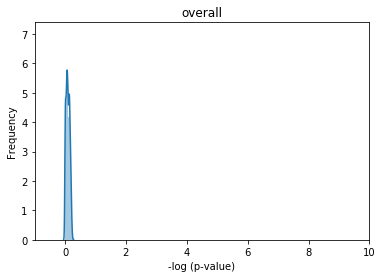

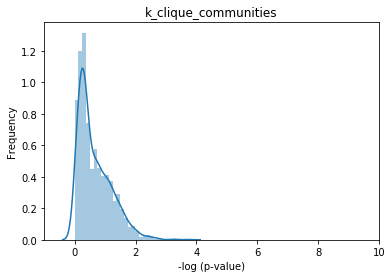

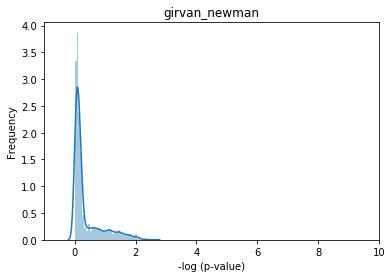

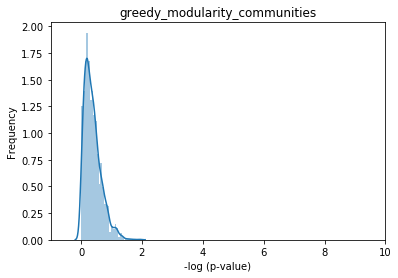

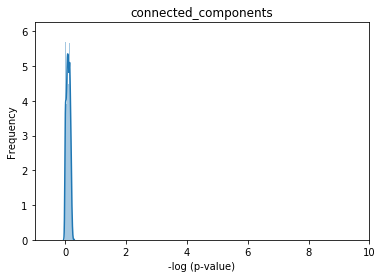

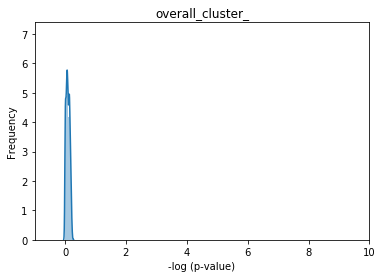

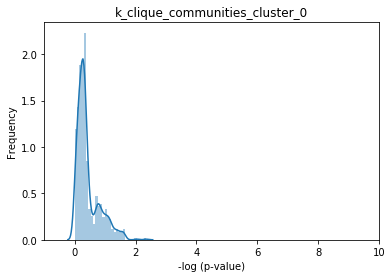

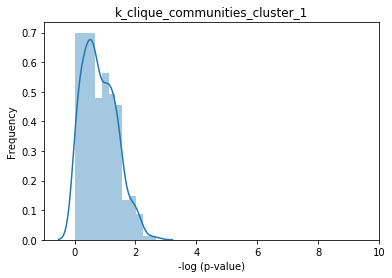

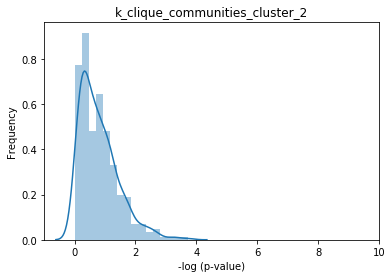

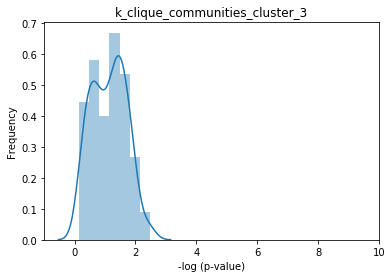

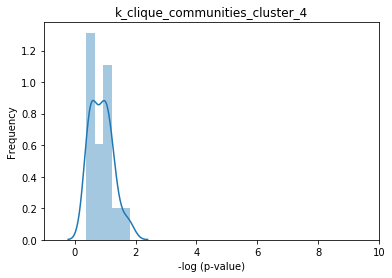

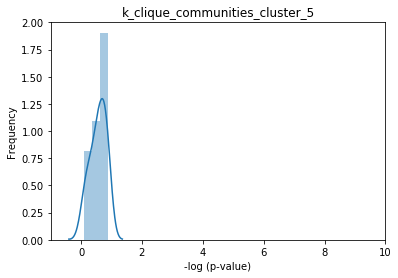

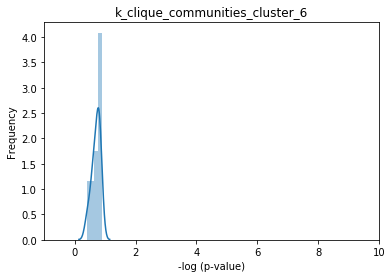

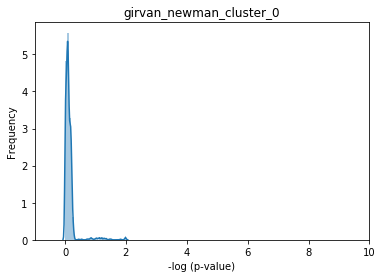

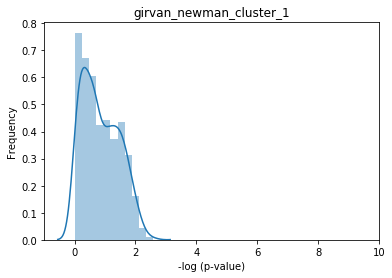

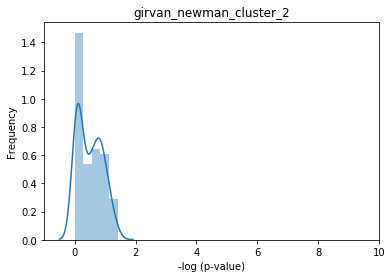

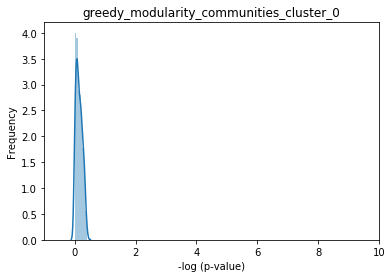

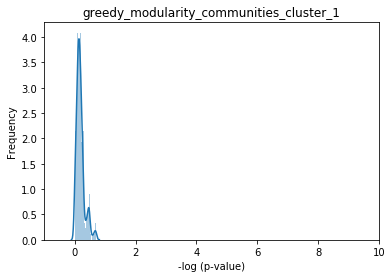

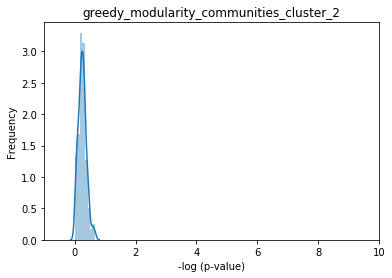

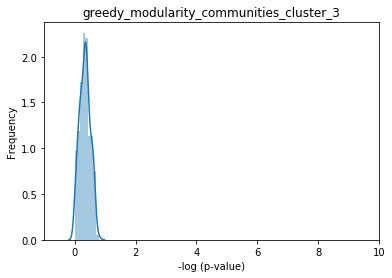

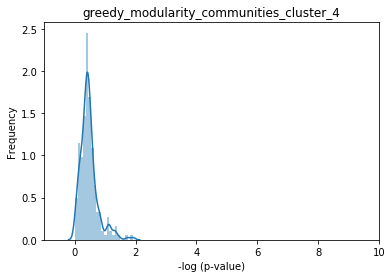

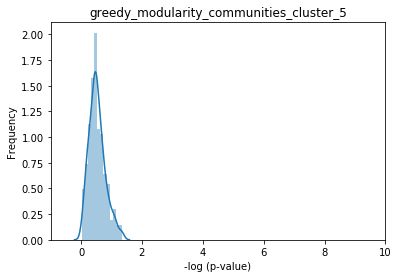

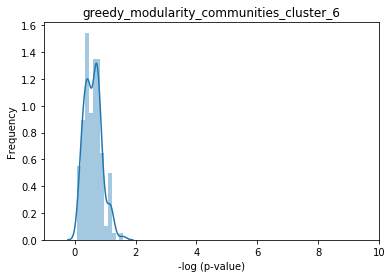

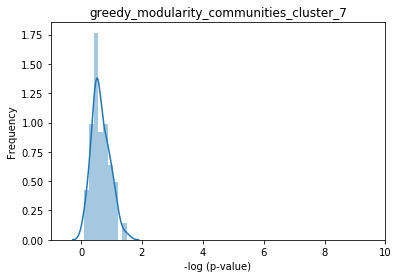

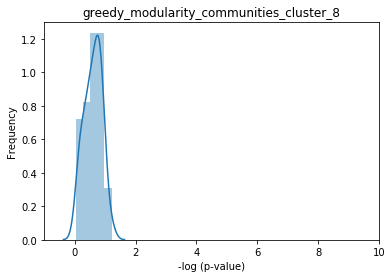

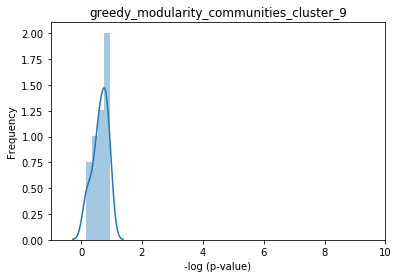

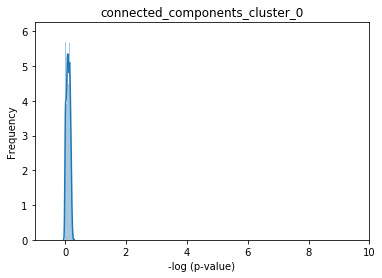

In [29]:
# plot one distribution per method

for clustering_method, y in neg_log_pvalues.items():
    fig, ax = plt.subplots()
    #print(len(y))
    sns.distplot(y, ax=ax, label=clustering_method)
    ax.set_title(clustering_method)
    ax.set_xlabel("-log (p-value)")
    ax.set_ylabel("Frequency")
    plt.xlim([-1,10])  

In [30]:
# plot one distribution per cluster

for cluster, y in neg_log_pvalues_cluster.items():
    fig, ax = plt.subplots()
    #print(len(y))
    sns.distplot(y, ax=ax, label=cluster)
    ax.set_title(cluster)
    ax.set_xlabel("-log (p-value)")
    ax.set_ylabel("Frequency")
    plt.xlim([-1,10])  

1700
1691
1697
1576
1700
1700
765
365
365
134
34
14
14
1099
499
99
212
212
212
212
212


<ipython-input-31-010d8ee4990c>:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



204


<ipython-input-31-010d8ee4990c>:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



160


<ipython-input-31-010d8ee4990c>:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



90


<ipython-input-31-010d8ee4990c>:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



42


<ipython-input-31-010d8ee4990c>:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



20


<ipython-input-31-010d8ee4990c>:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



1700


<ipython-input-31-010d8ee4990c>:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



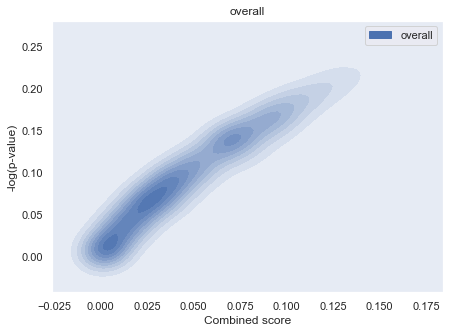

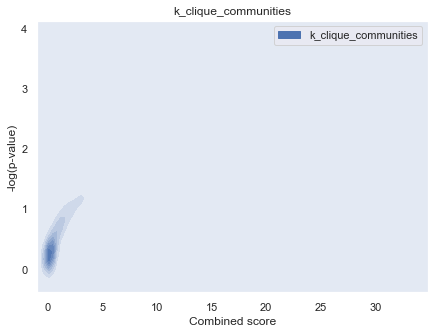

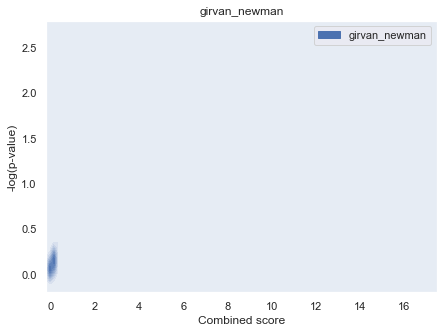

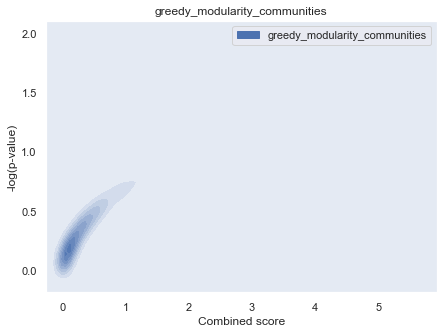

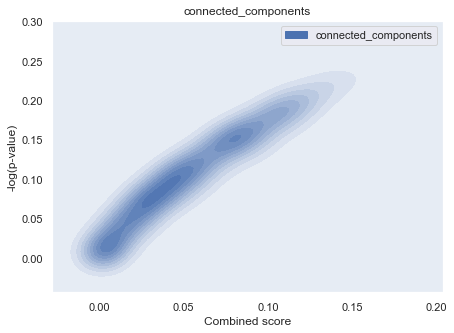

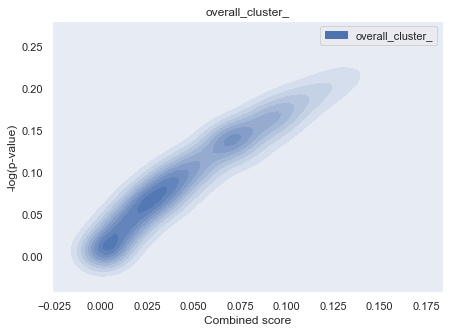

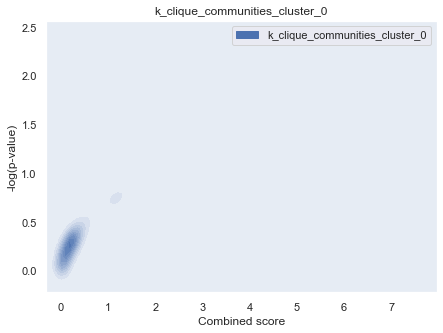

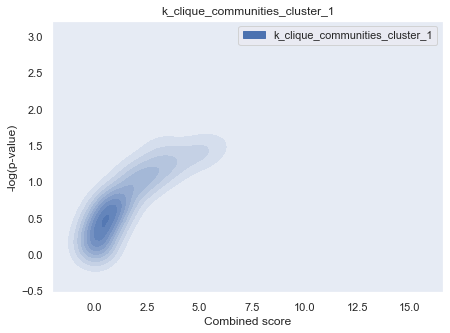

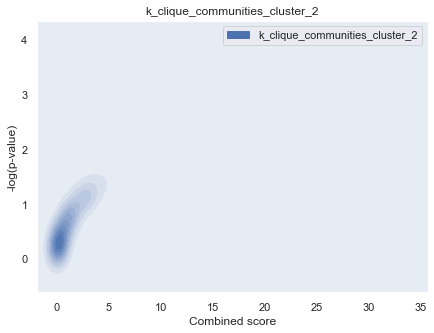

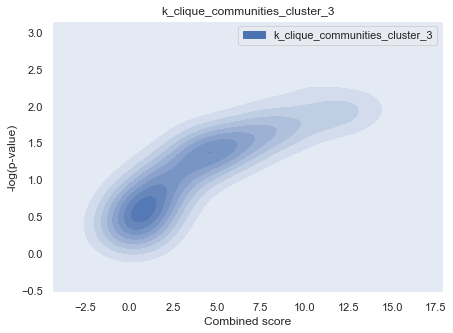

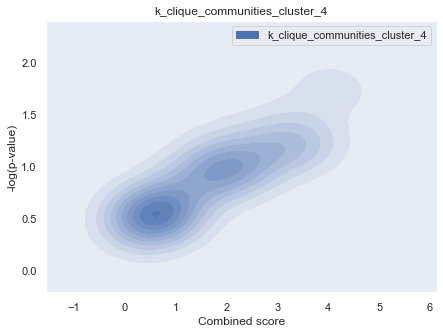

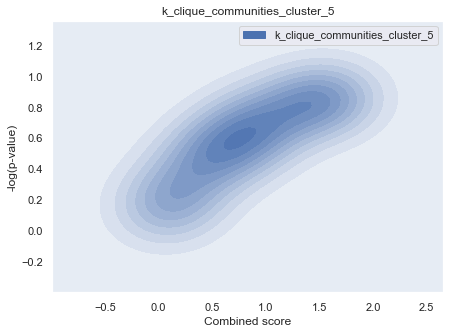

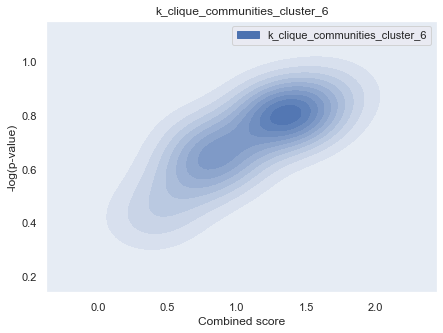

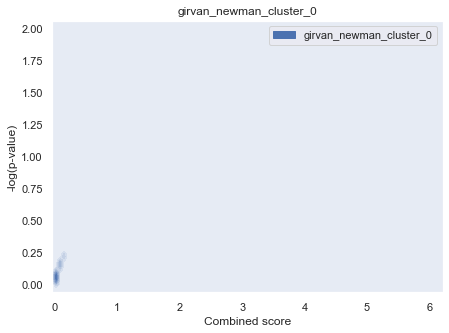

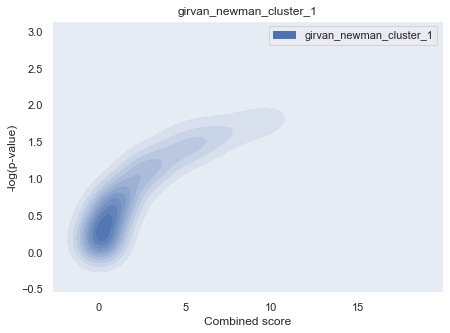

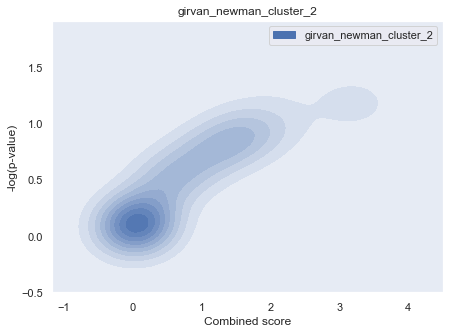

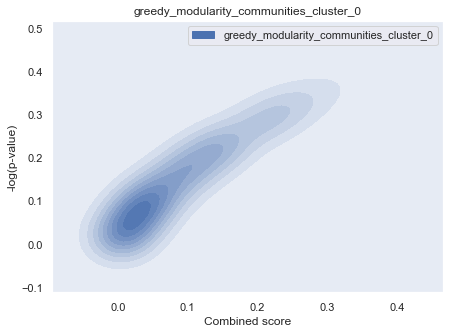

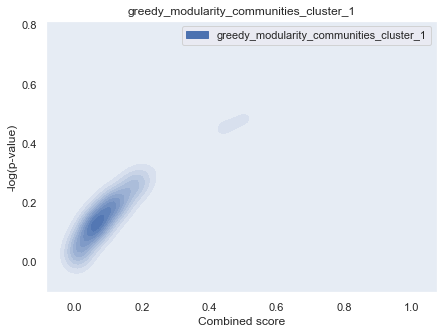

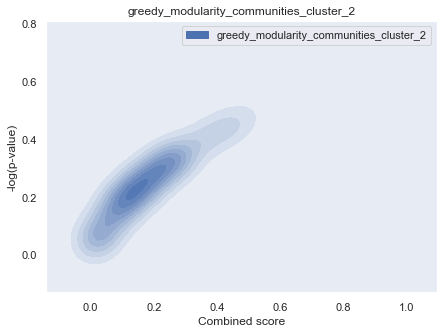

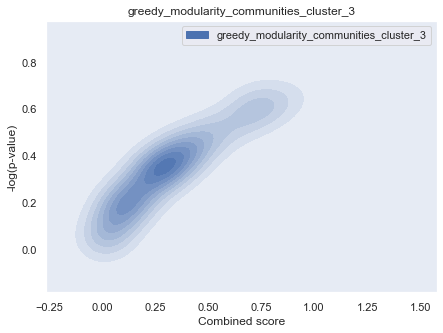

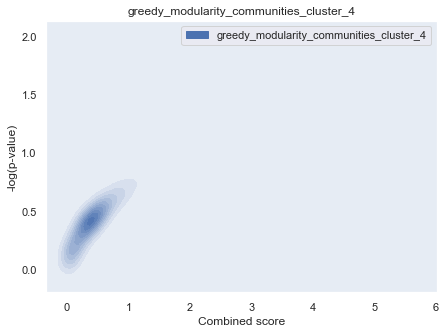

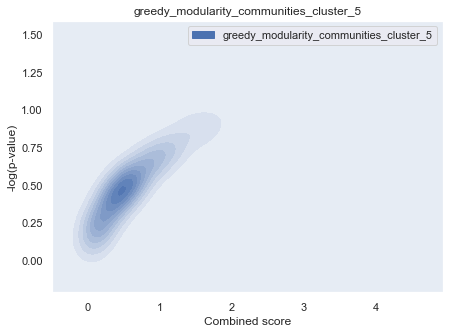

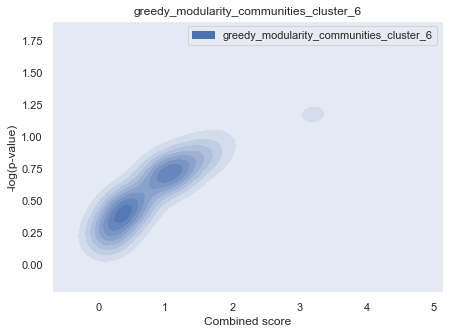

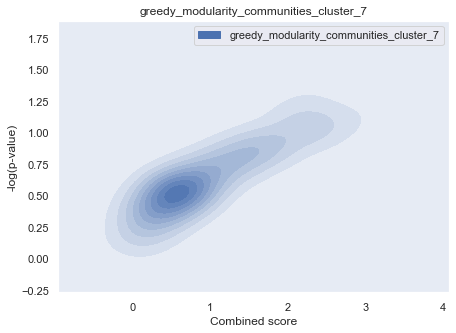

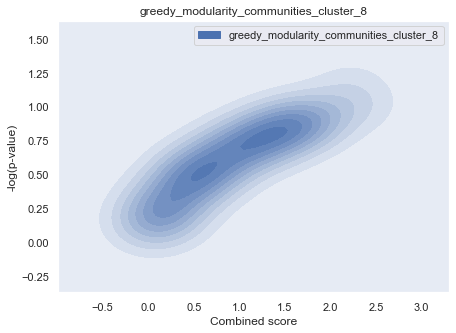

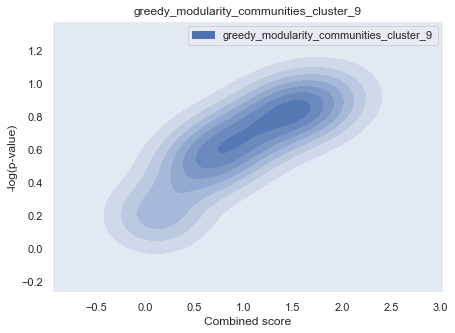

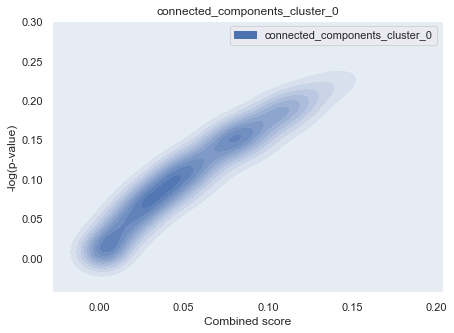

In [31]:
# Overlay the kernel density estimates of combined scores on a single plot
sns.set(color_codes=True)

for clustering_method, y in combined_scores.items():
    print(len(y))
    fig, ax = plt.subplots(figsize=(7,5))
    sns.kdeplot(y, neg_log_pvalues[clustering_method], label=clustering_method,shade=True)
    ax.set_title(clustering_method)
    ax.set_xlabel("Combined score")
    ax.set_ylabel("-log(p-value)")
    ax.legend()


In [33]:
# Overlay the kernel density estimates of combined scores on a single plot
# for each cluster

for cluster, y in combined_scores_cluster.items():
    print(len(y))
    fig, ax = plt.subplots(figsize=(7,5))
    sns.kdeplot(y, neg_log_pvalues_cluster[cluster], label=cluster,shade=True)
    ax.set_title(cluster)
    ax.set_xlabel("Combined score")
    ax.set_ylabel("-log(p-value)")
    ax.legend()

In [34]:
all_cluster_dfs = {}

clustering_results = []

for clustering_method, gene_lists in all_clusters.items():
    for num, clusters in gene_lists.items():
        for index,cluster in enumerate(clusters):
            for gene in cluster:
                data = {"gene": gene, "gene_list": num, "clustering_method": clustering_method, "cluster": index}     
                clustering_results.append(data)
df_clusters = pd.DataFrame(clustering_results)

display(df_clusters)  

,gene,gene_list,clustering_method,cluster
0,PKIB,0,k_clique_communities,0
1,COX7C,0,k_clique_communities,0
2,HSBP1,0,k_clique_communities,0
3,RPS23,0,k_clique_communities,0
4,ZCCHC10,0,k_clique_communities,0
...,...,...,...,...
26907,CPNE5,16,connected_components,0
26908,NCAPH,16,connected_components,0
26909,MANEA,16,connected_components,0
26910,LRRCC1,16,connected_components,0


In [35]:
# generate colors to color code clusters
def random_color():
    hex_number = "#000"
    while hex_number == "#000000":
        random_number = random.randint(0,16777215)
        hex_number = str(hex(random_number))
        hex_number ='#'+ hex_number[2:]
    return hex_number

In [42]:
cluster_colors = {}
edge_colors = {"PPI": "#bd34eb", "Coexpression": "#2dc2b0"}

os.makedirs("network_visualizations/PPI_and_coexpression_graphs",exist_ok=True)
os.makedirs("network_visualizations/PPI",exist_ok=True)
os.makedirs("network_visualizations/coexpression",exist_ok=True)

folder = "./network_visualizations/"

if len(edge_types) == 2:
    folder += "PPI_and_coexpression_graphs"
elif "Protein-protein interactions" in edge_types:
    folder += "PPI"
elif "Gene-gene co-expression" in edge_types:
    folder += "coexpression"

# make the clustering method graphs
for num, G in networks.items():
    for clustering_method in df_clusters.clustering_method.unique():
        
        df_method = df_clusters[df_clusters["clustering_method"] == clustering_method]
        df_method = df_method[df_method["gene_list"] == num]
    
        nt = net.Network(width="100%", height = 800, notebook=True)
        nt.from_nx(G)
        # nt.show_buttons()
        for node in nt.nodes:
            cluster = df_method[df_method["gene"] == node["id"]]
            if cluster.shape[0] == 0: node["color"] = "#000"
            else: 
                #print(cluster)
                cluster_num = cluster["cluster"].values[0]
                if not cluster_num in cluster_colors:
                    cluster_colors[cluster_num] = random_color()
                
                node["color"] = cluster_colors[cluster_num]
                
        for edge in nt.edges:
            edge["color"] = edge_colors[edge["edge_type"]]
            edge["title"] = edge["edge_type"]
        nt.prep_notebook()
        display(f"Gene list {num}, {clustering_method}")
        display(nt.show(f"{folder}/graph_{num}_{clustering_method}.html"))

'Gene list 0, k_clique_communities'

'Gene list 0, girvan_newman'

'Gene list 0, greedy_modularity_communities'

'Gene list 0, connected_components'

'Gene list 1, k_clique_communities'

'Gene list 1, girvan_newman'

'Gene list 1, greedy_modularity_communities'

'Gene list 1, connected_components'

'Gene list 2, k_clique_communities'

'Gene list 2, girvan_newman'

'Gene list 2, greedy_modularity_communities'

'Gene list 2, connected_components'

'Gene list 3, k_clique_communities'

'Gene list 3, girvan_newman'

'Gene list 3, greedy_modularity_communities'

'Gene list 3, connected_components'

'Gene list 4, k_clique_communities'

'Gene list 4, girvan_newman'

'Gene list 4, greedy_modularity_communities'

'Gene list 4, connected_components'

'Gene list 5, k_clique_communities'

'Gene list 5, girvan_newman'

'Gene list 5, greedy_modularity_communities'

'Gene list 5, connected_components'

'Gene list 6, k_clique_communities'

'Gene list 6, girvan_newman'

'Gene list 6, greedy_modularity_communities'

'Gene list 6, connected_components'

'Gene list 7, k_clique_communities'

'Gene list 7, girvan_newman'

'Gene list 7, greedy_modularity_communities'

'Gene list 7, connected_components'

'Gene list 8, k_clique_communities'

'Gene list 8, girvan_newman'

'Gene list 8, greedy_modularity_communities'

'Gene list 8, connected_components'

'Gene list 9, k_clique_communities'

'Gene list 9, girvan_newman'

'Gene list 9, greedy_modularity_communities'

'Gene list 9, connected_components'

'Gene list 10, k_clique_communities'

'Gene list 10, girvan_newman'

'Gene list 10, greedy_modularity_communities'

'Gene list 10, connected_components'

'Gene list 11, k_clique_communities'

'Gene list 11, girvan_newman'

'Gene list 11, greedy_modularity_communities'

'Gene list 11, connected_components'

'Gene list 12, k_clique_communities'

'Gene list 12, girvan_newman'

'Gene list 12, greedy_modularity_communities'

'Gene list 12, connected_components'

'Gene list 13, k_clique_communities'

'Gene list 13, girvan_newman'

'Gene list 13, greedy_modularity_communities'

'Gene list 13, connected_components'

'Gene list 14, k_clique_communities'

'Gene list 14, girvan_newman'

'Gene list 14, greedy_modularity_communities'

'Gene list 14, connected_components'

'Gene list 15, k_clique_communities'

'Gene list 15, girvan_newman'

'Gene list 15, greedy_modularity_communities'

'Gene list 15, connected_components'

'Gene list 16, k_clique_communities'

'Gene list 16, girvan_newman'

'Gene list 16, greedy_modularity_communities'

'Gene list 16, connected_components'

In [506]:
# comparison to STRING results

string_api_url = "https://string-db.org/api"
output_format = "json"
method = "interaction_partners"

request_url = "https://string-db.org/api/json/network"
nums_misses_string = []

for num, genes in gene_lists.items():
    params = {
        "identifiers" : "%0d".join(genes), # your protein
        "species": 9606
    }
    
    hits = set()
    
    response = requests.post(request_url, data=params)
    data = response.json()
    for interaction in data:
        hits.add(interaction["preferredName_A"])
        hits.add(interaction["preferredName_B"])
    
    misses = set()
    
    for gene in gene_list:
        if gene not in hits:
            misses.add(gene)
    
    print(f"{len(genes) - len(hits)} gene misses out of {len(genes)}\n")
    nums_misses_string.append(len(genes) - len(hits))      

127 gene misses out of 499

88 gene misses out of 499

95 gene misses out of 500

84 gene misses out of 500

88 gene misses out of 500

90 gene misses out of 500

53 gene misses out of 500

100 gene misses out of 500

141 gene misses out of 500

56 gene misses out of 500

66 gene misses out of 500

31 gene misses out of 500

42 gene misses out of 500

64 gene misses out of 420

54 gene misses out of 434

51 gene misses out of 447

164 gene misses out of 499



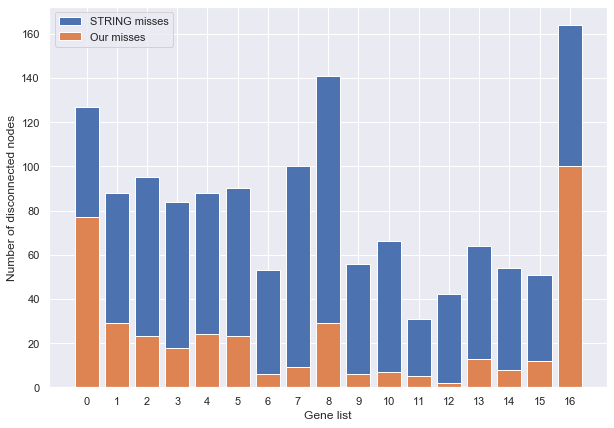

In [544]:
# Compare missing/disconnected nodes in our network to those in STRING

%matplotlib inline
gene_list_nums = [str(x) for x in gene_lists.keys()]
gene_list_sizes = [len(v) for k,v in gene_lists.items()]

fig, ax = plt.subplots(figsize=(10,7))

bar1 = plt.bar(gene_list_nums,nums_misses_string,label="STRING misses",color="#")
bar2 = plt.bar(gene_list_nums,nums_missing_nodes, label="Our misses",color="#")
ax.set_ylabel("Number of disconnected nodes")
ax.set_xlabel("Gene list")
ax.legend()
plt.show()

In [471]:
print(num_misses_string)
print(num_misses)

[127, 88, 95, 84, 88, 90, 53, 100, 141, 56, 66, 31, 42, 64, 54, 51, 164]
[73, 27, 20, 17, 19, 21, 5, 8, 29, 5, 7, 4, 2, 12, 6, 9, 94]


In [491]:
print("\n".join(gene_lists[0]))

RDM1
CRIPT
RNU5B-1
SMIM30
OTUD6B-AS1
MNS1
SDF2
UQCRHL
TIMM23
SAA1
COA6
TMEM126B
MT1E
PSMD10
CSTB
RBM34
TMEM60
AC078927.1
CDK7
ROMO1
NDUFS5
MAGOH
ARPC5
PTTG1
ZMAT2
HLA-E
SH3BGRL
AL138752.2
ACE2
TMEM14B
ZCRB1
LOC107984142
NDUFC1
RNF5
COX16
SUMO2
AC005083.1
LYZ
NEIL3
CLDN10
FBXL3
TIPRL
PPA2
CLTRN
ERGIC2
AMZ2
THAP2
MT1F
PSMB3
TIMP1
RPL36A-HNRNPH2
PPP1R2
LRRC31
YBX1P10
RN7SL832P
C4orf3
CHCHD2P2
MRPS21
ARL 14.00
AL445685.3
SYNJ2BP-COX16
SF3B5
UQCRQ
GATA6-AS1
PSMC1P1
DEK
CAPZB
SPAG7
AC134682.1
RPA3
CCNB1
PCNA
TMEM229B
COPS9
MZT1
NDUFS2
SVIP
NDUFA6
DERL2
RPS23
UBD
RSL24D1
AC124045.1
SRP72
TMA7
VTA1
EID1
EPHX1
APBB1
AC073548.1
PSMC2
UQCRH
TCN1
TMEM156
TRMT112
OAZ1
LRRCC1
SSBP1
CCNC
CYSTM1
CCDC115
MDK
CFH
FDCSP
CCDC34
ZNF85
SAA2
H1-5
ENY2
MRPL18
PPM1N
VPS28
GABBR1
CREBL2
SNHG6
TMEM14C
BLOC1S5
YBX1
PPA1
UBE2N
NUCB2
C12orf57
SERP1
SYF2
MGST3
SSB
MAD2L1
PGRMC1
RIDA
H2AC11
C11orf58
NDUFA12
IQCK
UQCR10
ZCCHC10
RPS26
NDUFA2
SMIM20
HMGB2
SLCO1B3
PET100
RBBP9
ARL6IP6
SRSF3
PON2
TNFSF10
TMSB4X
HLA-DMA
ID